# 3) NeuralBOW & Facebook Fasttext

## Load Dataset and Variables

In [1]:
import pandas as pd
import pickle

In [2]:
# Load the data

major_dialog_data = pd.read_pickle("./datasets/major_dialog_data.pkl")
all_dialog_data = pd.read_pickle("./datasets/all_dialog_data.pkl")

with open('./datasets/utterances.pkl', 'rb') as f:
    utterances = pickle.load(f)
    
with open('./datasets/stop_words.pkl', 'rb') as f:
    stop_words = pickle.load(f)

# Pre-process the data similarly to workbook 0

labels = major_dialog_data.speaker

speaker_value_counts = all_dialog_data.speaker.value_counts()
major_speaker_value_counts = speaker_value_counts[speaker_value_counts > 40]
x, y = major_speaker_value_counts.index, major_speaker_value_counts.values

num_major_characters = 6

# a list of the top characters names
major_characters = x[:num_major_characters]
# a set of those same names
major_characters_set = set(major_characters)

# finally, dicts to and from class Ids and their respective names
labels_to_ids = {}
ids_to_labels = {}
for i, major_character in enumerate(major_characters):
    labels_to_ids[major_character] = i
    ids_to_labels[i] = major_character
labels_to_ids

{'Rachel': 0, 'Ross': 1, 'Chandler': 2, 'Monica': 3, 'Joey': 4, 'Phoebe': 5}

## Model - Facebook Fasttext
[https://arxiv.org/abs/1607.01759](https://arxiv.org/abs/1607.01759)

This is a simple model with a word embedding layer followed by one hidden fully-connected layer. For this model, we'll train our own embeddings with an embedding dimension of 10. By training the embeddings from scratch, we might achieve more tailored embeddings for this particular corpus. We also use our own vocabulary. We'll include all words that appear in the training corpus 3 or more times.

In [2]:
import math
import models.fasttext as fasttext
import numpy as np
import re
import string
import tensorflow as tf

from collections import Counter, defaultdict
from datetime import datetime
from importlib import reload
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, classification_report
from util import shuffle, batch_iter, conf_matrix_plot

reload(fasttext)

<module 'models.fasttext' from '/home/richung/final/analysis/models/fasttext.py'>

In [10]:
counter = Counter()
stemmer = PorterStemmer()

# manully tokenize the sentences
custom_tokenized = []
for utterance in major_dialog_data.utterance:
    words = re.findall(r"[a-z0-9']+", utterance.lower())
    # remove dangling apostrophes and 's at the end of words
    words = [re.sub(r"'s?$", "", stemmer.stem(word)) for word in words]
    custom_tokenized.append(words)

# count all the tokens
for utterance in custom_tokenized:
    counter.update(word for word in utterance if word not in string.punctuation)

# filter to words of counts greater than 2
vocab = [k for k, v in counter.most_common() if v > 2]

# assign IDs to the words
vocab_word_to_id = defaultdict(lambda: -1)
vocab_id_to_word = {}
for i, word in enumerate(vocab):
    vocab_id_to_word[i] = word
    vocab_word_to_id[word] = i

In [16]:
train_cut = math.ceil(major_dialog_data.utterance.count() * 0.85)

label_ids = np.array([labels_to_ids[label] for label in labels])
train_x_fasttext = custom_tokenized[:train_cut]
train_y_fasttext = label_ids[:train_cut]
test_x_fasttext = custom_tokenized[train_cut:]
test_y_fasttext = label_ids[train_cut:]

train_x_fasttext = np.array([" ".join(words) for words in train_x_fasttext])
test_x_fasttext = np.array([" ".join(words) for words in test_x_fasttext])

In [23]:
tf.reset_default_graph()
fasttext_model = fasttext.FastText(vocab, num_major_characters, regularize_coef=0.1)

In [28]:
display_step = 20
num_epochs = 40
batch_size = 128

train_writer = tf.summary.FileWriter("./fasttext-board/train")
test_writer = tf.summary.FileWriter("./fasttext-board/test")
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    train_writer.add_graph(sess.graph)
    
    global_step = 0
    X = fasttext_model.X
    Y = fasttext_model.Y

    for epoch in range(num_epochs):
        print("{} epoch number: {}".format(datetime.now(), epoch + 1))
        train_x_fasttext, train_y_fasttext = shuffle(train_x_fasttext, train_y_fasttext)
        
        for step, x_batch, y_batch in batch_iter(train_x_fasttext, train_y_fasttext, batch_size):
            global_step += 1
            sess.run(fasttext_model.train_op, feed_dict={ X: x_batch, Y: y_batch })

            # every so often, report the progress of our loss and training accuracy
            if step % display_step == 0:
                summ = sess.run(fasttext_model.merged_summary, feed_dict={ X: x_batch, Y: y_batch })
                train_writer.add_summary(summ, global_step=global_step)
                train_writer.flush()

        test_acc, summ = sess.run([fasttext_model.accuracy, fasttext_model.merged_summary], feed_dict={ X: test_x_fasttext, Y: test_y_fasttext })
        test_writer.add_summary(summ, global_step=global_step)
        test_writer.flush()
        print("test accuracy = {:.4f}".format(test_acc))
    
    # save the model to disk so we can load it up later for use by `./eval.py`
    saver.save(sess, "./fasttext-ckpt/model.ckpt")

2018-12-05 07:06:27.837096 epoch number: 1
test accuracy = 0.1978
2018-12-05 07:06:30.752671 epoch number: 2
test accuracy = 0.1946
2018-12-05 07:06:31.900275 epoch number: 3
test accuracy = 0.1877
2018-12-05 07:06:32.961372 epoch number: 4
test accuracy = 0.1881
2018-12-05 07:06:33.933658 epoch number: 5
test accuracy = 0.1888
2018-12-05 07:06:34.880034 epoch number: 6
test accuracy = 0.1887
2018-12-05 07:06:35.816147 epoch number: 7
test accuracy = 0.1937
2018-12-05 07:06:36.775008 epoch number: 8
test accuracy = 0.1945
2018-12-05 07:06:37.781838 epoch number: 9
test accuracy = 0.2053
2018-12-05 07:06:38.921675 epoch number: 10
test accuracy = 0.2075
2018-12-05 07:06:39.831132 epoch number: 11
test accuracy = 0.2178
2018-12-05 07:06:41.034571 epoch number: 12
test accuracy = 0.2155
2018-12-05 07:06:42.150120 epoch number: 13
test accuracy = 0.2238
2018-12-05 07:06:43.405399 epoch number: 14
test accuracy = 0.2265
2018-12-05 07:06:44.454517 epoch number: 15
test accuracy = 0.2361
2018

This model is only slightly better. It looks like training embeddings from scratch doesn't help.

### FastText Evaluation

INFO:tensorflow:Restoring parameters from ./fasttext-ckpt/model.ckpt
              precision    recall  f1-score   support

      Rachel       0.27      0.48      0.35      1292
        Ross       0.28      0.28      0.28      1290
    Chandler       0.25      0.18      0.21      1173
      Monica       0.23      0.27      0.25      1115
        Joey       0.28      0.29      0.29      1081
      Phoebe       0.28      0.02      0.03       960

   micro avg       0.27      0.27      0.27      6911
   macro avg       0.27      0.25      0.23      6911
weighted avg       0.27      0.27      0.24      6911



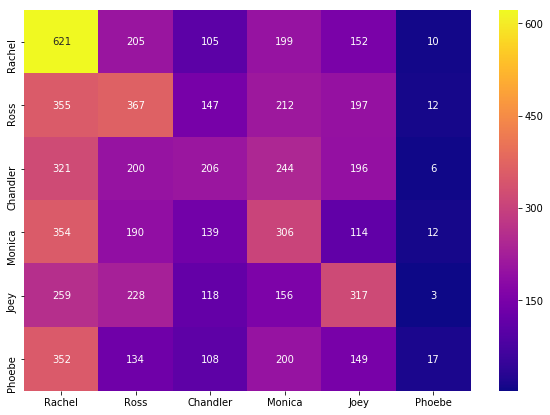

In [32]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./fasttext-ckpt/model.ckpt")
    sess.run(tf.tables_initializer())
    fasttext_test_preds = sess.run(fasttext_model.predictions, feed_dict={ fasttext_model.X: test_x_fasttext })
    
print(classification_report(test_y_fasttext, fasttext_test_preds, target_names=major_characters))

conf_matrix_plot(confusion_matrix(test_y_fasttext, fasttext_test_preds), major_characters)

## Model - General NeuralBOW

This leverages the model written for Assignment 2 on the television dataset to see if we can improve our accuracy

In [27]:
import math
import models.neuralbow as neuralbow
import numpy as np
import os, sys
import tensorflow as tf

from collections import Counter, defaultdict
from datetime import datetime
from importlib import reload
from nltk import word_tokenize
from w266_common import utils, vocabulary

reload(neuralbow)

<module 'models.neuralbow' from '/home/richung/final/analysis/models/neuralbow.py'>

In [25]:
character_counts = Counter()
for character in all_dialog_data.speaker:
    character_counts[character] += 1
    
top_characters = character_counts.most_common(6)

char_id_to_word = dict(enumerate([w for w, c in top_characters]))
char_word_to_id = {v:k for k,v in char_id_to_word.items()}

major_dialog_data = all_dialog_data[all_dialog_data.speaker.isin(char_word_to_id.keys())]

utterance_tokenized = [word_tokenize(sentence) for sentence in major_dialog_data.utterance]
vocab = vocabulary.Vocabulary(utils.canonicalize_word(w) for w in utils.flatten(utterance_tokenized))

In [18]:
max_len = 40

utterances_index = [vocab.words_to_ids(words) for words in utterance_tokenized]
speaker_index = np.array([char_word_to_id[speaker] for speaker in major_dialog_data.speaker])
utterances_index_nparray = np.zeros((len(utterances_index), max_len), dtype=np.int32)
utterances_length = np.zeros([len(utterances_index)], dtype=np.int32)

for i, row in enumerate(utterances_index):
    cpy_len = min(len(row), max_len)
    utterances_index_nparray[i,:cpy_len] = row[:cpy_len]
    utterances_length[i] = cpy_len
    
train_cut = math.ceil(major_dialog_data.utterance.count() * 0.6)
dev_cut = math.ceil(major_dialog_data.utterance.count() * 0.8)

train_x = utterances_index_nparray[:train_cut]
train_ns = utterances_length[:train_cut]
train_y = speaker_index[:train_cut]

dev_x = utterances_index_nparray[train_cut:dev_cut]
dev_ns = utterances_length[train_cut:dev_cut]
dev_y = speaker_index[train_cut:dev_cut]

test_x = utterances_index_nparray[dev_cut:]
test_ns = utterances_length[dev_cut:]
test_y = speaker_index[dev_cut:]

In [19]:
print(utterances_index_nparray.shape)
print(utterances_length.shape)
print(speaker_index.shape)

(46079, 40)
(46079,)
(46079,)


In [28]:
model_params = dict(V=vocab.size,
                    embed_dim=50,
                    hidden_dims=[25],
                    num_classes=6,
                    encoder_type='bow',
                    lr=0.1,
                    optimizer='adagrad',
                    beta=0.01)

checkpoint_dir = "/tmp/tf_bow_sst_" + datetime.now().strftime("%Y%m%d-%H%M")
if os.path.isdir(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

model = tf.estimator.Estimator(model_fn=neuralbow.classifier_model_fn, 
                               params=model_params,
                               model_dir=checkpoint_dir)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tf_bow_sst_20181205-0042', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe7b7812128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [30]:
train_params = dict(batch_size=32,
                    total_epochs=20,
                    eval_every=2)

assert(train_params['total_epochs'] % train_params['eval_every'] == 0)

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"ids": train_x,
       "ns": train_ns},
    y=train_y,
    batch_size=train_params['batch_size'], 
    num_epochs=train_params['eval_every'], shuffle=True)

dev_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"ids": dev_x,
       "ns": dev_ns},
    y=dev_y,
    batch_size=128,
    num_epochs=1,
    shuffle=False)

for _ in range(train_params['total_epochs'] // train_params['eval_every']):
    model.train(input_fn=train_input_fn)
    eval_metrics = model.evaluate(input_fn=dev_input_fn, name="dev")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tf_bow_sst_20181205-0042/model.ckpt.
INFO:tensorflow:loss = 2.7848978, step = 1
INFO:tensorflow:global_step/sec: 307.474
INFO:tensorflow:loss = 2.4486175, step = 101 (0.327 sec)
INFO:tensorflow:global_step/sec: 370.144
INFO:tensorflow:loss = 2.2564554, step = 201 (0.270 sec)
INFO:tensorflow:global_step/sec: 374.862
INFO:tensorflow:loss = 2.130189, step = 301 (0.267 sec)
INFO:tensorflow:global_step/sec: 370.16
INFO:tensorflow:loss = 2.0271716, step = 401 (0.270 sec)
INFO:tensorflow:global_step/sec: 375.827
INFO:tensorflow:loss = 1.9989741, step = 501 (0.266 sec)
INFO:tensorflow:global_step/sec: 369.21
INFO:tensorflow:loss = 1.964783, step = 601 (0.271 sec)
INFO:tensorflow:global_step/sec: 382.069
INFO:te

INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181205-0042/model.ckpt-5184
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-05-08:44:28
INFO:tensorflow:Saving dict for global step 5184: accuracy = 0.22873265, cross_entropy_loss = 1.7547423, global_step = 5184, loss = 1.8794646
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5184: /tmp/tf_bow_sst_20181205-0042/model.ckpt-5184
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181205-0042/model.ckpt-5184
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5184 into /tmp/tf_bow_sst_20181205-0042/model.ckpt.
INFO:tensorflow:loss = 1.774529, step = 5185
INFO:tensorflow:global_step/sec: 318.317
INFO:tens

INFO:tensorflow:global_step/sec: 374.028
INFO:tensorflow:loss = 1.7114259, step = 10141 (0.267 sec)
INFO:tensorflow:global_step/sec: 383.884
INFO:tensorflow:loss = 1.8001138, step = 10241 (0.260 sec)
INFO:tensorflow:global_step/sec: 383.205
INFO:tensorflow:loss = 1.7463328, step = 10341 (0.261 sec)
INFO:tensorflow:Saving checkpoints for 10368 into /tmp/tf_bow_sst_20181205-0042/model.ckpt.
INFO:tensorflow:Loss for final step: 1.7528093.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-05-08:44:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181205-0042/model.ckpt-10368
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-05-08:44:46
INFO:tensorflow:Saving dict for global step 10368: accuracy = 0.22374132, cross_entropy_loss = 1.7637719, global_step = 10368, loss = 1.9405373
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 375.147
INFO:tensorflow:loss = 1.5429366, step = 14625 (0.268 sec)
INFO:tensorflow:global_step/sec: 370.066
INFO:tensorflow:loss = 1.6778138, step = 14725 (0.269 sec)
INFO:tensorflow:global_step/sec: 377.231
INFO:tensorflow:loss = 1.6107802, step = 14825 (0.265 sec)
INFO:tensorflow:global_step/sec: 381.666
INFO:tensorflow:loss = 1.7395762, step = 14925 (0.262 sec)
INFO:tensorflow:global_step/sec: 382.56
INFO:tensorflow:loss = 1.5911927, step = 15025 (0.262 sec)
INFO:tensorflow:global_step/sec: 374.494
INFO:tensorflow:loss = 1.5562204, step = 15125 (0.266 sec)
INFO:tensorflow:global_step/sec: 394.879
INFO:tensorflow:loss = 1.5924369, step = 15225 (0.253 sec)
INFO:tensorflow:global_step/sec: 392.206
INFO:tensorflow:loss = 1.6578419, step = 15325 (0.255 sec)
INFO:tensorflow:global_step/sec: 395.251
INFO:tensorflow:loss = 1.634689, step = 15425 (0.254 sec)
INFO:tensorflow:global_step/sec: 388.427
INFO:tensorflow:loss = 1.7770305, step = 15525 (0.257 sec)
IN

In [31]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"ids": test_x,
       "ns": test_ns},
    y=test_y,
    batch_size=128,
    num_epochs=1,
    shuffle=False
)

eval_metrics = model.evaluate(input_fn=test_input_fn, name="test")

print("Accuracy on test set: {:.02%}".format(eval_metrics['accuracy']))
eval_metrics

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-05-08:45:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181205-0042/model.ckpt-17280
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-05-08:45:20
INFO:tensorflow:Saving dict for global step 17280: accuracy = 0.22788931, cross_entropy_loss = 1.8007401, global_step = 17280, loss = 2.013463
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 17280: /tmp/tf_bow_sst_20181205-0042/model.ckpt-17280
Accuracy on test set: 22.79%


{'accuracy': 0.22788931,
 'cross_entropy_loss': 1.8007401,
 'loss': 2.013463,
 'global_step': 17280}